# Anime Recommender System 

We will be creating an Hybrid Recommender System which is a combination of user based recommender system and content based recommender system. 

---------------


### 1. Importing Libraries

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Embedding, Flatten, Dot
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, EarlyStopping
from wordcloud import WordCloud 
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

- `from tensorflow.keras.models import Model` : Used to define custom models where you manually specify the inputs and outputs — great for building flexible architectures (like recommendation systems or multi-input models).

- `Dot`: Computes the dot product between two vectors — useful in recommendation systems to find similarity between user and item embeddings.

- `LearningRateScheduler` : Changes the learning rate as training goes on (e.g., gradually decrease it to fine-tune the model).

- `Embedding` : Turns integer inputs (like user or item IDs) into dense vectors (used in recommender systems, NLP, etc.).

In [3]:
INPUT_DIR = os.path.join('..','artifacts','raw')

In [4]:
rating_df = pd.read_csv(os.path.join(INPUT_DIR,'animelist.csv'),low_memory=True,usecols=['user_id','anime_id','rating'])

### 2. Understanding the data

In [5]:
rating_df.sample(10)

,user_id,anime_id,rating
57534035,186664,37320,6
77007808,249496,40532,0
74058737,239787,830,7
34597255,112246,30091,2
8559357,27948,7054,7
102142031,330068,41694,0
40743310,132130,934,9
85825089,277545,31798,0
55901348,181432,32948,6
106208462,343419,376,7


In [6]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109224747 entries, 0 to 109224746
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 2.4 GB


In [7]:
rating_df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,109224747.0,176809.803391,101848.727790,0.0,88491.0,177142.0,265187.0,353404.0
anime_id,109224747.0,16495.898684,13797.366207,1.0,3194.0,12445.0,30831.0,48492.0
rating,109224747.0,4.245717,3.912888,0.0,0.0,5.0,8.0,10.0


In [13]:
n_ratings = rating_df['user_id'].value_counts()
n_ratings

user_id
20807     17546
140590    17534
281232    17533
147331    17526
131988    17520
          ...  
259248        1
259247        1
345120        1
287410        1
307120        1
Name: count, Length: 325770, dtype: int64

In [16]:
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 100].index)]

In [17]:
rating_df

,user_id,anime_id,rating
74,1,37403,8
75,1,9989,0
76,1,24833,0
77,1,7674,7
78,1,34572,0
...,...,...,...
109224710,353403,4654,0
109224711,353403,14283,0
109224712,353403,16742,0
109224713,353403,1195,0


In [18]:
rating_df.duplicated().sum()

np.int64(1)

In [19]:
rating_df.drop_duplicates(inplace=True)

In [20]:
rating_df.duplicated().sum()

np.int64(0)

In [21]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

### 3. Normalization of rating

Using MinMaxScaler from `0–1` is a very good move for training efficiency and model performance.

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
rating_df['rating'] = scaler.fit_transform(rating_df[['rating']])

In [23]:
rating_df

,user_id,anime_id,rating
74,1,37403,0.8
75,1,9989,0.0
76,1,24833,0.0
77,1,7674,0.7
78,1,34572,0.0
...,...,...,...
109224710,353403,4654,0.0
109224711,353403,14283,0.0
109224712,353403,16742,0.0
109224713,353403,1195,0.0


In [24]:
rating_df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,105499228.0,176822.809355,101826.463476,1.0,88515.0,177177.0,265187.0,353403.0
anime_id,105499228.0,16657.367380,13806.054084,1.0,3363.0,12859.0,31056.0,48492.0
rating,105499228.0,0.421309,0.390226,0.0,0.0,0.5,0.8,1.0


### 4. Encoding - Decoding of User Id & Anime Id
Since these numbers are large numbers and not continuous → they don’t work well with neural network embedding layers, which require small, 0-based integer indices.

In [25]:
user_ids = rating_df['user_id'].unique().tolist()

In [26]:
user_ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 11,
 12,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 25,
 27,
 28,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 44,
 45,
 46,
 47,
 49,
 50,
 52,
 53,
 54,
 55,
 57,
 59,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 70,
 71,
 72,
 73,
 74,
 75,
 78,
 80,
 81,
 82,
 83,
 84,
 85,
 89,
 90,
 93,
 94,
 98,
 101,
 102,
 107,
 108,
 110,
 111,
 112,
 113,
 117,
 119,
 120,
 121,
 122,
 123,
 124,
 126,
 127,
 128,
 129,
 131,
 133,
 135,
 136,
 138,
 143,
 145,
 146,
 147,
 148,
 153,
 154,
 155,
 156,
 157,
 158,
 160,
 162,
 163,
 164,
 166,
 167,
 169,
 172,
 173,
 174,
 178,
 179,
 181,
 184,
 185,
 187,
 188,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 201,
 202,
 204,
 205,
 207,
 208,
 209,
 210,
 211,
 214,
 215,
 216,
 217,
 219,
 221,
 222,
 224,
 225,
 226,
 227,
 228,
 229,
 231,
 232,
 235,
 237,
 238,
 240,
 241,
 243,
 244,
 246,
 247,
 248,
 251,
 252,
 254,
 255,
 257,
 258,
 259,
 262,
 264,
 265,
 266,
 267,
 268,
 269,
 272,
 273,
 274,
 

In [27]:
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user2user_decoded = {i: x for i, x in enumerate(user_ids)}

In [28]:
user2user_encoded

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 11: 8,
 12: 9,
 14: 10,
 15: 11,
 16: 12,
 17: 13,
 19: 14,
 20: 15,
 21: 16,
 25: 17,
 27: 18,
 28: 19,
 32: 20,
 33: 21,
 34: 22,
 36: 23,
 37: 24,
 38: 25,
 39: 26,
 40: 27,
 41: 28,
 42: 29,
 44: 30,
 45: 31,
 46: 32,
 47: 33,
 49: 34,
 50: 35,
 52: 36,
 53: 37,
 54: 38,
 55: 39,
 57: 40,
 59: 41,
 60: 42,
 61: 43,
 62: 44,
 64: 45,
 65: 46,
 66: 47,
 67: 48,
 70: 49,
 71: 50,
 72: 51,
 73: 52,
 74: 53,
 75: 54,
 78: 55,
 80: 56,
 81: 57,
 82: 58,
 83: 59,
 84: 60,
 85: 61,
 89: 62,
 90: 63,
 93: 64,
 94: 65,
 98: 66,
 101: 67,
 102: 68,
 107: 69,
 108: 70,
 110: 71,
 111: 72,
 112: 73,
 113: 74,
 117: 75,
 119: 76,
 120: 77,
 121: 78,
 122: 79,
 123: 80,
 124: 81,
 126: 82,
 127: 83,
 128: 84,
 129: 85,
 131: 86,
 133: 87,
 135: 88,
 136: 89,
 138: 90,
 143: 91,
 145: 92,
 146: 93,
 147: 94,
 148: 95,
 153: 96,
 154: 97,
 155: 98,
 156: 99,
 157: 100,
 158: 101,
 160: 102,
 162: 103,
 163: 104,
 164: 105,
 166: 106,
 167: 10

In [29]:
user2user_decoded

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 11,
 9: 12,
 10: 14,
 11: 15,
 12: 16,
 13: 17,
 14: 19,
 15: 20,
 16: 21,
 17: 25,
 18: 27,
 19: 28,
 20: 32,
 21: 33,
 22: 34,
 23: 36,
 24: 37,
 25: 38,
 26: 39,
 27: 40,
 28: 41,
 29: 42,
 30: 44,
 31: 45,
 32: 46,
 33: 47,
 34: 49,
 35: 50,
 36: 52,
 37: 53,
 38: 54,
 39: 55,
 40: 57,
 41: 59,
 42: 60,
 43: 61,
 44: 62,
 45: 64,
 46: 65,
 47: 66,
 48: 67,
 49: 70,
 50: 71,
 51: 72,
 52: 73,
 53: 74,
 54: 75,
 55: 78,
 56: 80,
 57: 81,
 58: 82,
 59: 83,
 60: 84,
 61: 85,
 62: 89,
 63: 90,
 64: 93,
 65: 94,
 66: 98,
 67: 101,
 68: 102,
 69: 107,
 70: 108,
 71: 110,
 72: 111,
 73: 112,
 74: 113,
 75: 117,
 76: 119,
 77: 120,
 78: 121,
 79: 122,
 80: 123,
 81: 124,
 82: 126,
 83: 127,
 84: 128,
 85: 129,
 86: 131,
 87: 133,
 88: 135,
 89: 136,
 90: 138,
 91: 143,
 92: 145,
 93: 146,
 94: 147,
 95: 148,
 96: 153,
 97: 154,
 98: 155,
 99: 156,
 100: 157,
 101: 158,
 102: 160,
 103: 162,
 104: 163,
 105: 164,
 106: 166,
 107: 16

In [30]:
rating_df['user'] = rating_df['user_id'].map(user2user_encoded)

In [31]:
rating_df.head()

,user_id,anime_id,rating,user
74,1,37403,0.8,0
75,1,9989,0.0,0
76,1,24833,0.0,0
77,1,7674,0.7,0
78,1,34572,0.0,0


In [32]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x : i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i, x in enumerate(anime_ids)}

In [33]:
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoded)

In [34]:
rating_df.head()

,user_id,anime_id,rating,user,anime
74,1,37403,0.8,0,0
75,1,9989,0.0,0,1
76,1,24833,0.0,0,2
77,1,7674,0.7,0,3
78,1,34572,0.0,0,4


### 5. Splitting the Data for Model Building

In [35]:
x = rating_df[['user', 'anime']]
y = rating_df['rating']

In [36]:
x

,user,anime
74,0,0
75,0,1
76,0,2
77,0,3
78,0,4
...,...,...
109224710,241588,803
109224711,241588,1821
109224712,241588,812
109224713,241588,578


In [37]:
y

74           0.8
75           0.0
76           0.0
77           0.7
78           0.0
            ... 
109224710    0.0
109224711    0.0
109224712    0.0
109224713    0.0
109224714    0.0
Name: rating, Length: 105499228, dtype: float64

In [38]:
rating_df.shape

(105499228, 5)

In [41]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.01, random_state=42)

In [44]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [49]:
x_train

array([[203122,   4445],
       [225181,    918],
       [ 82381,   4191],
       ...,
       [130479,   2162],
       [130195,    736],
       [150613,   1546]])

In [46]:
x_train_array = [x_train[:,0],x_train[:,1]]
x_test_array = [x_test[:,0],x_test[:,1]]

In [47]:
x_train_array

[array([203122, 225181,  82381, ..., 130479, 130195, 150613]),
 array([4445,  918, 4191, ..., 2162,  736, 1546])]

In [48]:
x_test_array

[array([169248, 240632,  57257, ...,  58219, 226825, 114357]),
 array([1420,  639, 3985, ..., 1432, 4706, 4806])]

### 6. Build the Model Architecture

In [51]:
def RecommenderNet():
    embedding_size = 128
    user = Input(name='user',shape=[1])
    user_embedding = Embedding(name='user_embedding',input_dim=len(user2user_encoded),output_dim=embedding_size)(user)
    anime = Input(name='anime',shape=[1])
    anime_embedding = Embedding(name='anime_embedding',input_dim=len(anime2anime_encoded),output_dim=embedding_size)(anime)
    x = Dot(name='dot_product',normalize=True,axes=2)([user_embedding,anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=[user,anime],outputs=x)
    model.compile(loss='binary_crossentropy',metrics=['mae','mse'],optimizer='Adam')
    return model
    

In [52]:
model = RecommenderNet()

In [53]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │ 30,923,392 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,247,936 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,171,334 (126.54 MB)

 Trainable params: 33,171,332 (126.54 MB)

 Non-trainable params: 2 (8.00 B)

In [54]:
start_lr = 1e-6
max_lr = 1e-4
min_lr = 5e-6
batch_size = 100000
ramup_epochs = 3
sustain_epochs = 2
exp_decay = 0.05

def lrfn(epoch):
    if epoch < ramup_epochs:
        lr = (max_lr - start_lr) / ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        lr = max_lr
    else:
        lr = (max_lr - min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr
    return lr


In [56]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)

In [57]:
my_callbacks = [lr_callback, checkpoint_callback, early_stopping_callback]

In [58]:
history = model.fit(
    x = x_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20, 
    validation_data = (x_test_array, y_test),
    callbacks = my_callbacks,
    verbose = 1
)

Epoch 1/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 93s 87ms/step - loss: 0.7820 - mae: 0.3830 - mse: 0.1943 - val_loss: 0.7814 - val_mae: 0.3828 - val_mse: 0.1940 - learning_rate: 1.0000e-06
Epoch 2/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 91s 85ms/step - loss: 0.7789 - mae: 0.3824 - mse: 0.1932 - val_loss: 0.7697 - val_mae: 0.3806 - val_mse: 0.1897 - learning_rate: 3.4000e-05
Epoch 3/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 92s 86ms/step - loss: 0.7504 - mae: 0.3721 - mse: 0.1815 - val_loss: 0.6681 - val_mae: 0.3283 - val_mse: 0.1455 - learning_rate: 6.7000e-05
Epoch 4/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 92s 86ms/step - loss: 0.6195 - mae: 0.3019 - mse: 0.1241 - val_loss: 0.5824 - val_mae: 0.2770 - val_mse: 0.1080 - learning_rate: 1.0000e-04
Epoch 5/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 92s 87ms/step - loss: 0.5671 - mae: 0.2685 - mse: 0.1013 - val_loss: 0.5599 - val_mae: 0.2621 - val_mse: 0.0985 - learning_rate: 1.0000e-04
Epoch 6/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 91s 85ms/step - loss: 0.5462 - mae: 0.2537 - mse

In [60]:
pd.DataFrame(history.history)

,loss,mae,mse,val_loss,val_mae,val_mse,learning_rate
0,0.781983,0.382970,0.194303,0.781358,0.382799,0.194045,1.000000e-06
1,0.776062,0.381864,0.192134,0.769691,0.380592,0.189734,3.400000e-05
2,0.727762,0.361378,0.171787,0.668064,0.328342,0.145476,6.700000e-05
3,0.601015,0.290274,0.116012,0.582366,0.276992,0.107971,1.000000e-04
4,0.562197,0.265097,0.099252,0.559870,0.262088,0.098478,1.000000e-04
5,0.542825,0.250992,0.091390,0.544424,0.250298,0.092373,1.000000e-04
6,0.531005,0.242371,0.086638,0.543125,0.249589,0.091847,9.750000e-06
7,0.529401,0.241180,0.086001,0.542322,0.248957,0.091539,5.237500e-06
8,0.528397,0.240426,0.085611,0.541579,0.248369,0.091256,5.011875e-06
9,0.527431,0.239702,0.085240,0.540846,0.247774,0.090980,5.000594e-06


Text(0.5, 1.0, 'Loss Curve')

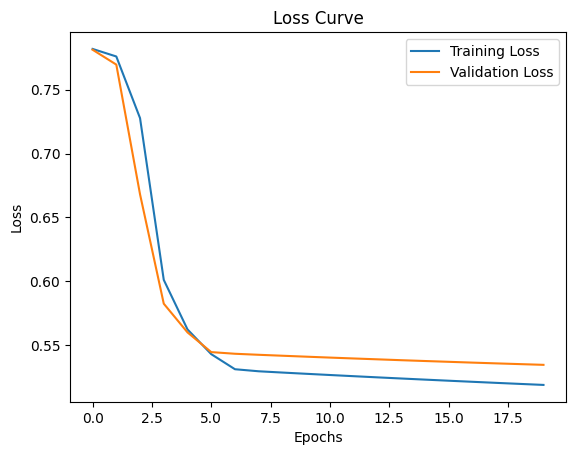

In [62]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

Text(0.5, 1.0, 'MAE Curve')

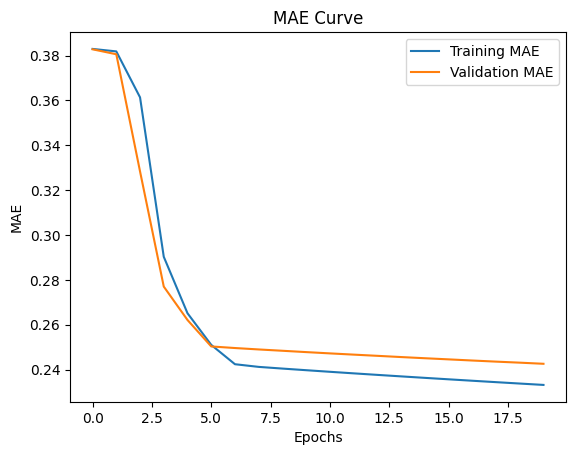

In [63]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE Curve')

Text(0.5, 1.0, 'MSE Curve')

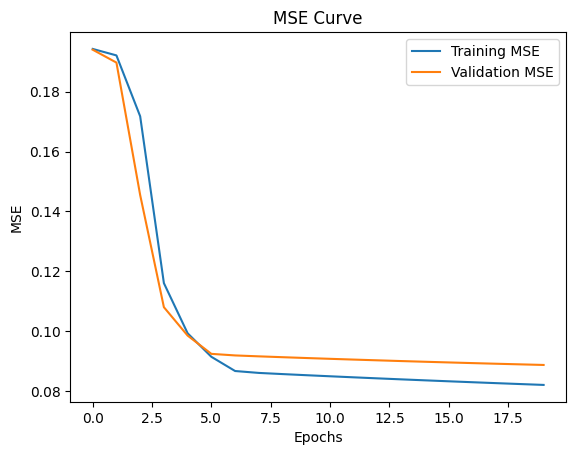

In [64]:
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE Curve')

Text(0.5, 1.0, 'Learning Rate Schedule')

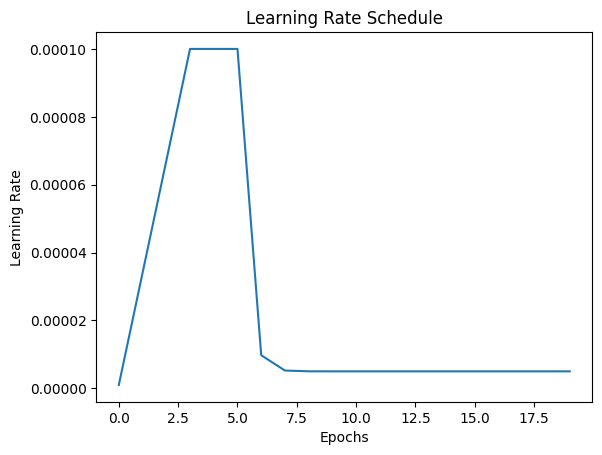

In [65]:
lrs = [lrfn(epoch) for epoch in range(len(history.history['loss']))]
plt.plot(lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

### 7. Extracting & Normalizing the Weight Matrix

In [66]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis=1).reshape(-1,1)
    return weights

In [ ]:
anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

### 8. Working with anime.csv

In [68]:
df = pd.read_csv(os.path.join(INPUT_DIR,'anime.csv'),low_memory=True)
df.sample(10)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
3773,4689,Kaze no Toori Michi,6.01,"Music, Kids",The Path of Wind,カゼノトオリミチ,Music,1,"Dec 8, 2004",Unknown,Unknown,Unknown,"Studio Ghibli, Ajia-Do",Original,4 min.,G - All Ages,8197.0,7792,3038,2,47,1852,29,35,1075,42.0,44.0,139.0,259.0,374.0,299.0,91.0,39.0,24.0,20.0
9525,26293,Kokoro no Hanataba,Unknown,Kids,Unknown,心の花たば,OVA,1,2001,Unknown,Gakken,Unknown,Unknown,Unknown,13 min.,G - All Ages,15117.0,16419,117,0,6,31,4,35,41,3.0,6.0,2.0,3.0,2.0,Unknown,Unknown,Unknown,Unknown,1.0
7084,14049,Mashiro-iro Symphony: Airi ga Anata no Kanojo ...,6.16,"Harem, Romance",Unknown,ましろ色シンフォニー- 愛理があなたの彼女に!？,Special,1,"Jan 25, 2012",Unknown,Unknown,Unknown,Manglobe,Unknown,14 min.,PG-13 - Teens 13 or older,7547.0,4973,9652,6,255,6379,149,156,2713,257.0,216.0,421.0,898.0,1003.0,686.0,305.0,169.0,112.0,85.0
13616,36399,Yumehito: Yumejin,Unknown,"Music, Kids",Unknown,夢人～ユメジン～,Music,1,"Aug 1, 2007",Unknown,NHK,Unknown,Unknown,Original,4 min.,G - All Ages,13044.0,16720,103,0,8,47,3,22,23,4.0,Unknown,1.0,4.0,4.0,7.0,4.0,4.0,1.0,5.0
4396,5962,Metal Fight Beyblade,6.68,"Adventure, Comedy, Sports",Metal Fight Beyblade,メタルファイト ベイブレード,TV,51,"Apr 5, 2009 to Mar 28, 2010",Spring 2009,Unknown,Nelvana,"Tatsunoko Production, SynergySP, Seven",Manga,25 min. per ep.,PG - Children,5000.0,2111,55471,257,1431,47495,1080,2180,3285,2681.0,2387.0,5362.0,10127.0,8094.0,4764.0,1656.0,731.0,367.0,210.0
1352,1490,Ginga Tetsudou Monogatari,7.16,"Action, Adventure, Drama, Sci-Fi, Space",The Galaxy Railways,銀河鉄道物語,TV,26,"Oct 4, 2003 to Apr 4, 2004",Fall 2003,"Ginga Ya, Studio Kyuuma, Trilogy Future Studio",Funimation,Planet,Original,24 min. per ep.,PG-13 - Teens 13 or older,2934.0,4953,9724,45,504,3046,557,573,5044,176.0,270.0,588.0,830.0,429.0,231.0,79.0,38.0,13.0,17.0
8354,20919,Diabolik Lovers Recap,5.39,"Shoujo, Vampire",Unknown,DIABOLIK LOVERS 総集編【Episode6.5】,Special,1,"Oct 28, 2013",Unknown,"Frontier Works, Idea Factory, Sentai Filmworks...",Unknown,"Production I.G, Zexcs",Visual novel,15 min.,PG-13 - Teens 13 or older,9958.0,3633,20424,65,409,16075,171,250,3519,713.0,411.0,665.0,1311.0,1778.0,1968.0,965.0,674.0,602.0,720.0
14444,37711,Koi to Uso OVA,6.42,"Drama, Romance, School",Love and Lies,恋と嘘,OVA,2,"Nov 16, 2018",Unknown,Unknown,Unknown,LIDENFILMS,Manga,14 min. per ep.,PG-13 - Teens 13 or older,6333.0,3227,25829,39,886,10979,551,285,13128,390.0,354.0,863.0,2065.0,2031.0,1012.0,398.0,163.0,101.0,83.0
2307,2520,Dragon Ball Specials,6.73,"Fantasy, Comedy, Super Power, Shounen",Dragon Ball Specials,ドラゴンボール,Special,2,"Jun 8, 1988",Unknown,Unknown,Unknown,Toei Animation,Manga,12 min. per ep.,PG - Children,4759.0,3274,25108,39,340,20660,215,258,3635,1463.0,867.0,1626.0,3020.0,2658.0,1727.0,593.0,237.0,140.0,101.0
8326,20745,Love Live! School Idol Project OVA,6.86,"Music, Slice of Life, School",Unknown,ラブライブ! School idol project OVA,OVA,1,"Nov 27, 2013",Unknown,Lantis,Unknown,Sunrise,Other,15 min.,PG-13 - Teens 13 or older,4198.0,2513,40941,167,528,33632,240,175,6366,2263.0,1697.0,3427.0,6415.0,4900.0,2500.0,904.0,358.0,202.0,164.0


In [69]:
df.replace('Unknown',np.nan,inplace=True)

In [70]:
df

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",NaN,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,盗墓笔记之秦岭神树,ONA,NaN,"Apr 4, 2021 to ?",NaN,NaN,NaN,NaN,Novel,NaN,NaN,NaN,13116,354,6,0,0,0,0,354,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,見える子ちゃん,TV,NaN,2021 to ?,NaN,Kadokawa,NaN,Passione,Manga,NaN,NaN,NaN,17562,7010,70,14,0,14,0,6982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17559,48488,Higurashi no Naku Koro ni Sotsu,NaN,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,NaN,"Jul, 2021 to ?",Summer 2021,NaN,NaN,NaN,Visual novel,NaN,R - 17+ (violence & profanity),NaN,17558,11309,48,3,0,0,0,11306,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,ヤマノススメ Next Summit,TV,NaN,NaN,NaN,Kadokawa,NaN,8bit,Manga,NaN,PG-13 - Teens 13 or older,NaN,17565,1386,2,13,2,2,1,1368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          12421 non-null  object
 3   Genres         17499 non-null  object
 4   English name   6997 non-null   object
 5   Japanese name  17514 non-null  object
 6   Type           17525 non-null  object
 7   Episodes       17046 non-null  object
 8   Aired          17253 non-null  object
 9   Premiered      4745 non-null   object
 10  Producers      9768 non-null   object
 11  Licensors      3946 non-null   object
 12  Studios        10483 non-null  object
 13  Source         13995 non-null  object
 14  Duration       17007 non-null  object
 15  Rating         16874 non-null  object
 16  Ranked         15800 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [72]:
def getAnimeName(anime_id):
    try:
        anime_row = df[df['MAL_ID'] == anime_id]
        if not anime_row.empty:
            english_name = anime_row['English name'].values[0]
            original_name = anime_row['Name'].values[0]
            
            if pd.notna(english_name):
                return english_name
            else:
                return original_name
        else:
            return "Anime ID not found"
    except Exception as e:
        print("Error in getting anime name for ID:", anime_id, "|", e)
        return None

In [73]:
anime67 = getAnimeName(67)

In [74]:
anime67

'Basilisk'

In [76]:
getAnimeName(6702)

'Fairy Tail'

In [77]:
df['eng_version'] = df['MAL_ID'].apply(getAnimeName)

In [78]:
df.sort_values(by='Score',
inplace=True, ascending=False, kind='quicksort', na_position='last')

In [81]:
df = df[['MAL_ID','eng_version','Score','Genres','Episodes','Type','Premiered','Members']]

In [82]:
df

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121
...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,ONA,NaN,354
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,TV,NaN,7010
17559,48488,Higurashi:When They Cry – SOTSU,NaN,"Mystery, Dementia, Horror, Psychological, Supe...",NaN,TV,Summer 2021,11309
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,TV,NaN,1386


In [83]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df['MAL_ID']==anime]
    elif isinstance(anime,str):
        return df[df['eng_version'].str.contains(anime,case=False,na=False)]
    else:
        return pd.DataFrame()

In [84]:
getAnimeFrame(40028 , df)

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [86]:
getAnimeFrame('naruto' , df)

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Premiered,Members
1574,1735,Naruto:Shippuden,8.16,"Action, Adventure, Comedy, Super Power, Martia...",500,TV,Winter 2007,1543765
10,20,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martia...",220,TV,Fall 2002,1830540
7549,16870,The Last:Naruto the Movie,7.76,"Action, Super Power, Romance, Martial Arts, Sh...",1,Movie,NaN,352160
7021,13667,Road to Ninja:Naruto the Movie,7.67,"Action, Adventure, Super Power, Martial Arts, ...",1,Movie,NaN,223826
9862,28755,Boruto:Naruto the Movie,7.5,"Action, Comedy, Martial Arts, Shounen, Super P...",1,Movie,NaN,320603
6285,10589,Naruto: Shippuuden Movie 5 - Blood Prison,7.46,"Action, Adventure, Martial Arts, Super Power, ...",1,Movie,NaN,160912
8088,19511,Naruto: Shippuuden - Sunny Side Battle,7.43,"Action, Comedy, Super Power, Martial Arts, Sho...",1,Special,NaN,43524
5304,8246,Naruto: Shippuuden Movie 4 - The Lost Tower,7.42,"Action, Comedy, Martial Arts, Shounen, Super P...",1,Movie,NaN,172051
11340,32365,Boruto: Naruto the Movie - Naruto ga Hokage ni...,7.4,"Action, Comedy, Super Power, Martial Arts, Sho...",1,Special,NaN,76018
6055,10075,Naruto x UT,7.4,"Action, Comedy, Super Power, Martial Arts, Sho...",1,OVA,NaN,40027


In [87]:
getAnimeFrame('Naruto the Movie:Ninja Clash in the Land of Snow',df)

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Premiered,Members
414,442,Naruto the Movie:Ninja Clash in the Land of Snow,7.1,"Adventure, Comedy, Historical, Supernatural, D...",1,Movie,NaN,215046


### 9. Working with anime_with_synopsis.csv

In [91]:
cols = ['MAL_ID','Name','Genres','sypnopsis']
synopsis_df = pd.read_csv(os.path.join(INPUT_DIR,'anime_with_synopsis.csv'),usecols=cols,low_memory=True)

In [92]:
synopsis_df

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,"Adventure, Mystery, Supernatural",No synopsis information has been added to this...
16210,48483,Mieruko-chan,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...
16211,48488,Higurashi no Naku Koro ni Sotsu,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to Higurashi no Naku Koro ni Gou .
16212,48491,Yama no Susume: Next Summit,"Adventure, Slice of Life, Comedy",New Yama no Susume anime.


In [99]:
def getSynopsis(anime,df):
    if isinstance(anime,int):
        return df[df['MAL_ID']==anime]['sypnopsis'].values[0]
    elif isinstance(anime,str):
        return df[df['Name'].str.contains(anime,case=False,na=False)]['sypnopsis'].values[0]
    else:
        return pd.DataFrame()

In [100]:
getSynopsis(40028,synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [101]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### 10. Content/Item based Recommendation Code

In [102]:
pd.options.display.max_colwidth = None

In [105]:
synopsis_df[:1]

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [106]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    index = getAnimeFrame(name, df)['MAL_ID'].values[0]
    encoded_index = anime2anime_encoded.get(index)

    weights = anime_weights

    # Compute the similarity distance
    dists = np.dot(weights, weights[encoded_index])
    sorted_dists = np.argsort(dists)

    n = n + 1  # Add 1 to include the input anime (we will remove it later)

    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    if return_dist:
        return dists, closest

    similarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
        synopsis = getSynopsis(decoded_id, synopsis_df)
        anime_frame = getAnimeFrame(decoded_id, df)
        anime_name = anime_frame['eng_version'].values[0]
        genre = anime_frame['Genres'].values[0]
        similarity = dists[close]
        similarityArr.append({
            'anime_id': decoded_id,
            'name': anime_name,
            'similarity': similarity,
            'genre': genre,
            'synopsis': synopsis,
        })

    Frame = pd.DataFrame(similarityArr).sort_values(by='similarity', ascending=False).reset_index(drop=True)

    # Remove the original anime and drop 'anime_id' column
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [108]:
find_similar_animes("Steins;Gate",anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=5)

,name,similarity,genre,synopsis
1,Fate/Zero Season 2,0.949970,"Action, Supernatural, Magic, Fantasy","s the Fourth Holy Grail War rages on with no clear victor in sight, the remaining Servants and their Masters are called upon by Church supervisor Risei Kotomine, in order to band together and confront an impending threat that could unravel the Grail War and bring about the destruction of Fuyuki City. The uneasy truce soon collapses as Masters demonstrate that they will do anything in their power, no matter how despicable, to win. Seeds of doubt are sown between Kiritsugu Emiya and Saber, his Servant, as their conflicting ideologies on heroism and chivalry clash. Meanwhile, an ominous bond forms between Kirei Kotomine, who still seeks to find his purpose in life, and one of the remaining Servants. As the countdown to the end of the war reaches zero, the cost of winning begins to blur the line between victory and defeat."
2,Fullmetal Alchemist:Brotherhood,0.925352,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen","""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."
3,Fate/Zero,0.923054,"Action, Supernatural, Magic, Fantasy","h the promise of granting any wish, the omnipotent Holy Grail triggered three wars in the past, each too cruel and fierce to leave a victor. In spite of that, the wealthy Einzbern family is confident that the Fourth Holy Grail War will be different; namely, with a vessel of the Holy Grail now in their grasp. Solely for this reason, the much hated ""Magus Killer"" Kiritsugu Emiya is hired by the Einzberns, with marriage to their only daughter Irisviel as binding contract. Kiritsugu now stands at the center of a cutthroat game of survival, facing off against six other participants, each armed with an ancient familiar, and fueled by unique desires and ideals. Accompanied by his own familiar, Saber, the notorious mercenary soon finds his greatest opponent in Kirei Kotomine, a priest who seeks salvation from the emptiness within himself in pursuit of Kiritsugu. Based on the light novel written by Gen Urobuchi, Fate/Zero depicts the events of the Fourth Holy Grail War—10 years prior to Fate/stay night . Witness a battle royale in which no one is guaranteed to survive."
4,Code Geass:Lelouch of the Rebellion R2,0.922332,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the E

### 11. User based Recommendation Code

In [120]:
def find_similar_user(user, user_weights, user2user_encoded, user2user_decoded, n=10, return_dist=False, neg=False):
    index = user 
    encoded_index = user2user_encoded.get(index)
    weights = user_weights 

    dists = np.dot(weights,weights[encoded_index])
    sorted_dists = np.argsort(dists)

    n = n+1 # Add 1 to include the input user (we will remove it later)

    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]
    
    if return_dist:
        return dists, closest
    
    similarityArr = []
    for close in closest:
        decoded_id = user2user_decoded.get(close)
        similarity = dists[close]
        similarityArr.append({
            'user_id': decoded_id,
            'similarity': similarity
        })
    Frame = pd.DataFrame(similarityArr).sort_values(by='similarity', ascending=False).reset_index(drop=True)
    return Frame[Frame['user_id'] != index]

In [121]:
find_similar_user(11880, user_weights, user2user_encoded, user2user_decoded, n=5)

,user_id,similarity
1,301603,0.477299
2,250378,0.438994
3,129615,0.435314
4,176083,0.433555
5,9165,0.426624


In [127]:
find_similar_user(1495, user_weights, user2user_encoded, user2user_decoded, n=5)

,user_id,similarity
1,39541,0.473735
2,143956,0.448437
3,142159,0.444715
4,100289,0.439706
5,124687,0.430007


only give those `User IDs` on which we trained our model.

### 12. Creating the Word Cloud for Genre

In [128]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')

In [131]:
df.head(1)['Genres'].str.split(',')

3971    [Action,  Military,  Adventure,  Comedy,  Drama,  Magic,  Fantasy,  Shounen]
Name: Genres, dtype: object

In [132]:
from collections import defaultdict

def getFavGenre(data, plot=False):
    data.dropna(inplace=True)
    all_genres = defaultdict(int)
    genres_list = []
    for genres in data['Genres'].str.split(','):
        for genre in genres:
            all_genres[genre.strip()] += 1
            genres_list.append(genre.strip())
    
    if plot:
        showWordCloud(all_genres)
    
    return genres_list

In [133]:
x = getAnimeFrame(1, df)

In [134]:
x

,MAL_ID,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


In [135]:
getFavGenre(x, plot=False)

['Action', 'Adventure', 'Comedy', 'Drama', 'Sci-Fi', 'Space']

['Action', 'Adventure', 'Comedy', 'Drama', 'Sci-Fi', 'Space']

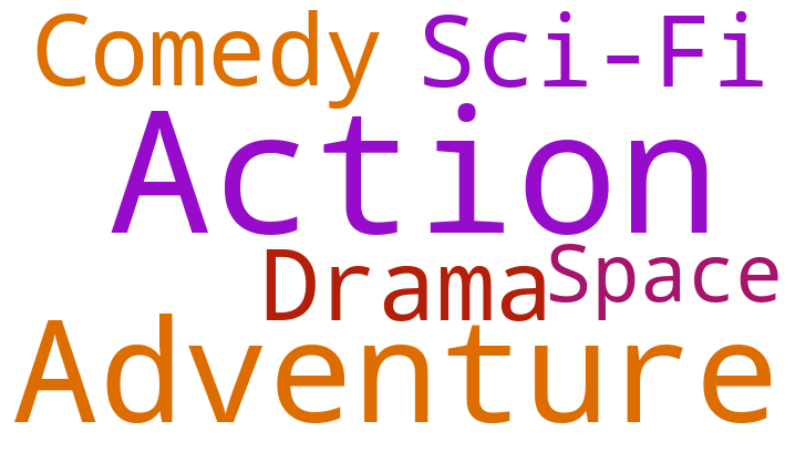

In [136]:
getFavGenre(x, plot=True)

In [139]:
def get_user_preferences(user_id, rating_df, df, plot=False):
    animes_watched_by_user = rating_df[rating_df['user_id'] == user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user['rating'], 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user['rating'] >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by='rating', ascending=False)['anime_id'].values
    )

    top_animes_df = df[df['MAL_ID'].isin(top_animes_user)]
    top_animes_df = top_animes_df[['eng_version', 'Genres']]

    if plot:
        getFavGenre(top_animes_df, plot=True)
    
    return top_animes_df

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


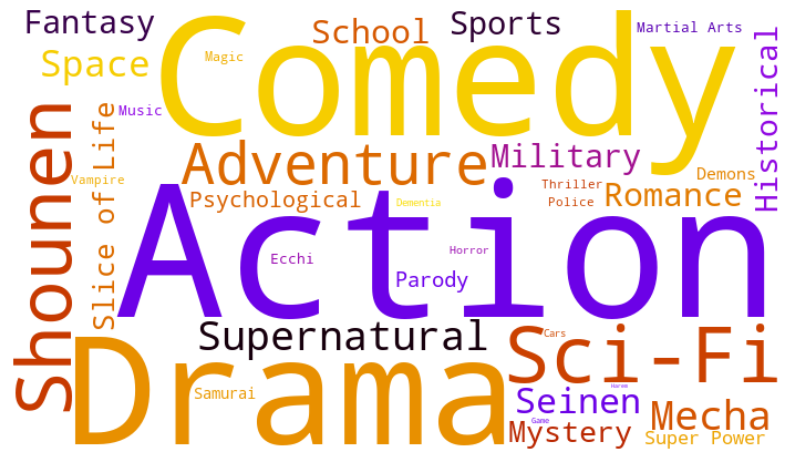

In [140]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [163]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.user_id.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.MAL_ID.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [164]:
similar_users =find_similar_user(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [165]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [167]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=3)

,n,anime_name,Genres,Synopsis
0,7,anohana:The Flower We Saw That Day,"Slice of Life, Supernatural, Drama","Jinta Yadomi is peacefully living as a recluse, spending his days away from school and playing video games at home instead. One hot summer day, his childhood friend, Meiko ""Menma"" Honma, appears and pesters him to grant a forgotten wish. He pays her no mind, which annoys her, but he doesn't really care. After all, Menma already died years ago. At first, Jinta thinks that he is merely hallucinating due to the summer heat, but he is later on convinced that what he sees truly is the ghost of Menma. Jinta and his group of childhood friends grew apart after her untimely death, but they are drawn together once more as they try to lay Menma's spirit to rest. Re-living their pain and guilt, will they be able to find the strength to help not only Menma move on—but themselves as well?"
1,7,Clannad,"Slice of Life, Comedy, Supernatural, Drama, Romance","Clannad: After Story , the sequel to the critically acclaimed slice-of-life series Clannad , begins after Tomoya Okazaki and Nagisa Furukawa graduate from high school. Together, they experience the emotional rollercoaster of growing up. Unable to decide on a course for his future, Tomoya learns the value of a strong work ethic and discovers the strength of Nagisa's support. Through the couple's dedication and unity of purpose, they push forward to confront their personal problems, deepen their old relationships, and create new bonds. Time also moves on in the Illusionary World. As the plains grow cold with the approach of winter, the Illusionary Girl and the Garbage Doll are presented with a difficult situation that reveals the World's true purpose. Based on the visual novel by Key and produced by Kyoto Animation, Clannad: After Story is an impactful drama highlighting the importance of family and the struggles of adulthood."
2,7,Nisekoi:False Love,"Harem, Comedy, Romance, School, Shounen","aku Ichijou, a first-year student at Bonyari High School, is the sole heir to an intimidating yakuza family. Ten years ago, Raku made a promise to his childhood friend. Now, all he has to go on is a pendant with a lock, which can only be unlocked with the key which the girl took with her when they parted. Now, years later, Raku has grown into a typical teenager, and all he wants is to remain as uninvolved in his yakuza background as possible while spending his school days alongside his middle school crush Kosaki Onodera. However, when the American Bee Hive Gang invades his family's turf, Raku's idyllic romantic dreams are sent for a toss as he is dragged into a frustrating conflict: Raku is to pretend that he is in a romantic relationship with Chitoge Kirisaki, the beautiful daughter of the Bee Hive's chief, so as to reduce the friction between the two groups. Unfortunately, reality could not be farther from this whopping lie—Raku and Chitoge fall in hate at first sight, as the girl is convinced he is a pathetic pushover, and in Raku's eyes, Chitoge is about as attractive as a savage gorilla. Nisekoi follows the daily antics of this mismatched couple who have been forced to get along for the sake of maintaining the city's peace. With many more girls popping up his life, all involved with Raku's past somehow, his search for the girl who holds his heart and his promise leads him in more unexpected directions than he expects."


### 13. Hybrid Recommendation System

In [170]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_user(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [171]:
hybrid_recommendation(11880)

['Code Geass:Lelouch of the Rebellion',
 'Code Geass:Lelouch of the Rebellion R2',
 'anohana:The Flower We Saw That Day',
 'Angel Beats!',
 'Toradora!',
 'Steins;Gate',
 'Clannad',
 'Clannad ~After Story~',
 'Fullmetal Alchemist:Brotherhood',
 'Death Note']